In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Text cleaning
import re, string
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import Counter

pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ISSS609/IMDB Dataset_clean.csv')
df.head()

,Unnamed: 0,review,sentiment,clean,length,label
0,0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,one review mention watch 1 oz episod youll hook right exactli happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort viewingthat get touch darker side,167,1
1,1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive,wonder littl product ing techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir

In [ ]:
x = df['clean']
y = df['label']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
x_train_orig, x_test_orig, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=2022)

# sentiment - Bert-base 

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 29.0 MB/s 
     |████████████████████████████████| 7.6 MB 56.0 MB/s 
     |████████████████████████████████| 163 kB 57.5 MB/s 


In [ ]:
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model

In [ ]:
import transformers
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True) # bert-base
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
# tokenizers from the tokenizers package are faster as the tokenizers from transformers because they are implemented in Rust.
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True) 
fast_tokenizer

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [ ]:
# fast_encode: convert text intput into ids, ie. numeric input that model can understand 
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    #truncation and padding will ensure that the max_length is strictly adhered
    tokenizer.enable_truncation(max_length=maxlen) 
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
# faster to generate train and test data, otherwise took forever
x_train = fast_encode(x_train_orig.values, fast_tokenizer, maxlen=400) 
x_test = fast_encode(x_test_orig.values, fast_tokenizer, maxlen=400)

In [ ]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    net = tf.keras.layers.Dropout(0.1)(cls_token)
    net = Dense(100, activation='relu')(net)
    #out = Dense(1, activation='sigmoid')(cls_token) #output layer
    out = Dense(1, activation='sigmoid')(net) #output layer
    model = Model(inputs=input_word_ids, outputs=out)
    #tf.keras.layers.Dropout(0.1)(net)
    model.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
for layer in bert_model.layers:
  layer.trainable = False

In [ ]:
model = build_model(bert_model, max_len=400)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 400)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 400,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                             

In [ ]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 5)

Epoch 1/5
1240/1240 [==============================] - 1800s 1s/step - loss: 0.3640 - accuracy: 0.8290 - val_loss: 0.2795 - val_accuracy: 0.8807
Epoch 2/5
1240/1240 [==============================] - 1799s 1s/step - loss: 0.2260 - accuracy: 0.9092 - val_loss: 0.2635 - val_accuracy: 0.8947
Epoch 3/5
1240/1240 [==============================] - 1799s 1s/step - loss: 0.1508 - accuracy: 0.9415 - val_loss: 0.2701 - val_accuracy: 0.9019
Epoch 4/5
1240/1240 [==============================] - 1799s 1s/step - loss: 0.0887 - accuracy: 0.9678 - val_loss: 0.3121 - val_accuracy: 0.9004
Epoch 5/5
1240/1240 [==============================] - 1799s 1s/step - loss: 0.0521 - accuracy: 0.9815 - val_loss: 0.3387 - val_accuracy: 0.9024


In [ ]:
model.save('/content/drive/MyDrive/ISSS609/bert_base_01.h5')

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

310/310 [==============================] - 141s 453ms/step - loss: 0.3387 - accuracy: 0.9024


In [ ]:
# plot function
def plot_curve(hist):
    epochs = hist.epoch
    f, ax = plt.subplots(ncols=2, figsize=(20,8))
    ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
    ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
    ax[1].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

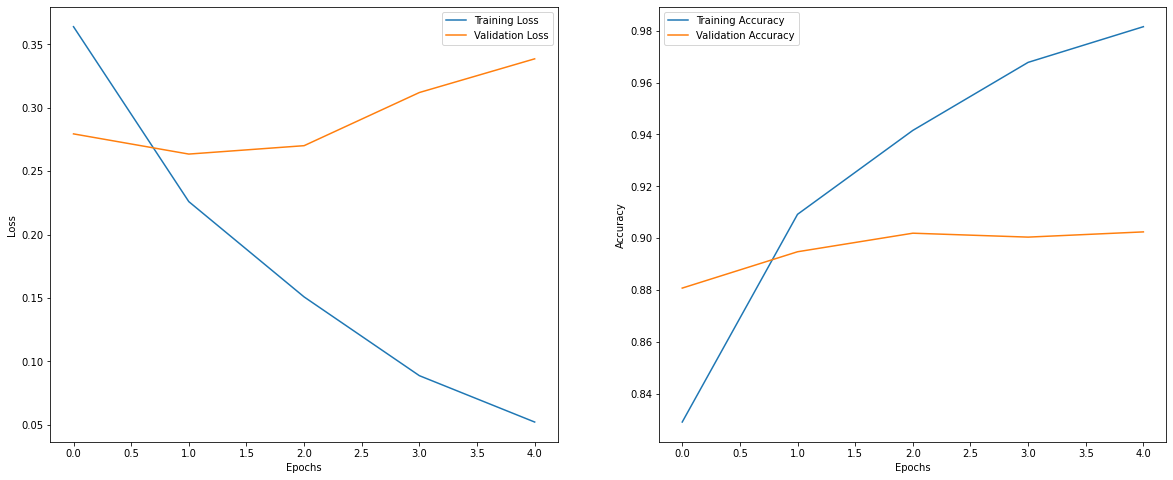

In [ ]:
plot_curve(history)

In [ ]:
pred = model.predict(x_test)
pred = np.round(pred).astype(int)
print(classification_report(y_test, pred, target_names = ['Negative','Positive']))

310/310 [==============================] - 140s 446ms/step
              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      4940
    Positive       0.89      0.91      0.90      4977

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



# sentiment - bert_base class

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 6.8 MB/s 
     |████████████████████████████████| 7.6 MB 26.0 MB/s 
     |████████████████████████████████| 163 kB 73.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import transformers
from keras.models import load_model
from sklearn.model_selection import train_test_split
from tokenizers import BertWordPieceTokenizer
import warnings; warnings.filterwarnings('ignore')

In [ ]:
df_raw = pd.read_csv('/content/drive/MyDrive/ISSS609/IMDB Dataset01_clean.csv')
df_raw.head()

,Unnamed: 0,ID,REVIEW,RATING,AUTHOR,TITLE,clean,length,label
0,1,2,I cannot believe anyone could give this film l...,8.0,joemay-2,What are all the bad reviews about is it a wo...,can not believ anyon could give less 6 gave 8 ...,21,1
1,6,7,Much better than the ratings suggest. Its on p...,9.0,Novelwolf,Nice Shark movie!\n,much better rate suggest par mani shark one ke...,21,1
2,10,11,"At least well 2/3's of the movie, its grumpy m...",3.0,ops-52535,its raft fever...\n,least well 23 grumpi men voulner women old tho...,117,0
3,11,12,Many have tried to replicate the success of St...,3.0,seventhriotontheship,Jaws 57\n,mani tri replic success steven spielberg jaw y...,30,0
4,12,13,"When u come to watch a typical shark movie , y...",1.0,hossamahmed-30148,Below average\n,u come watch typic shark definetli expect see ...,36,0


In [ ]:
class SentimentBert:
  def __init__(self):
    self.model = None
    # First load the real tokenizer
    self.tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True) # bert-base
    # Save the loaded tokenizer locally
    self.tokenizer.save_pretrained('.')
    # Reload it with the huggingface tokenizers library
    self.fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
    self.bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # get_data
    df = pd.read_csv('/content/drive/MyDrive/ISSS609/IMDB Dataset_clean.csv')
    x = df['clean']
    y = df['label']
    self.x_train_orig, self.x_test_orig, self.y_train, self.y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=2022)
    self.x_train = self.fast_encode(self.x_train_orig.values, self.fast_tokenizer, maxlen=400)
    self.x_test = self.fast_encode(self.x_test_orig.values, self.fast_tokenizer, maxlen=400)
  
  def fast_encode(self, texts, tokenizer, chunk_size=256, maxlen=400):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

  def build_model(self, transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
  def load_model(self):
    self.model = load_model('/content/drive/MyDrive/ISSS609/bert_base.h5', custom_objects={'TFDistilBertModel': self.bert_model})

  def evaluate(self):
    print("Accuracy of the model on Testing Data is - " , self.model.evaluate(self.x_test, self.y_test)[1]*100 , "%")
    pred = model.predict(self.x_test)
    pred = np.round(pred).astype(int)
    print(classification_report(self.y_test, pred, target_names = ['Negative','Positive']))

  def test_single(self, review):
    review = self.fast_encode(np.array([review]), self.fast_tokenizer, maxlen=400)
    prediction = np.round(self.model.predict(review)).astype(int)
    if prediction == 0 : return 'Negative'
    return 'Positive'
if __name__ == '__main__':
    sentiment_bert = SentimentBert()
    sentiment_bert.load_model()
    sentiment_bert.evaluate()

    record = df_raw.sample(1)
    article = record['REVIEW'].values[0]
    rating = record['RATING'].values[0]
    print('Original Review: ')
    print(article)
    print('====================================================')
    print('RATING:', rating)
    print('====================================================')
    print(sentiment_bert.test_single(article))
    '''
    summaraizer = Ext_text_summarizer(article)
    result = summaraizer._run_article_summary(summaraizer.para)
    print(result)
    print('====================================================')
    print(summaraizer._get_rouge_score(article, result))
    '''

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


  7/310 [..............................] - ETA: 2:02:46 - loss: 0.2195 - accuracy: 0.9330

KeyboardInterrupt: ignored

# Text Summarization abstraction - T5

In [ ]:
!unzip '/content/drive/MyDrive/ISSS609/IMDB Dataset.csv.zip'

Archive:  /content/drive/MyDrive/ISSS609/IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


In [ ]:
!pip install Rouge
from rouge import Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install transformers
from rouge import Rouge
from transformers import pipeline
import warnings; warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 23.6 MB/s 
     |████████████████████████████████| 163 kB 62.1 MB/s 
     |████████████████████████████████| 6.6 MB 58.4 MB/s 


In [ ]:
summarizer = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
import pandas as pd
df_raw=pd.read_csv('IMDB Dataset.csv')
df_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
[[reciew1], [review2]]

In [ ]:
df_raw.sample(1)['review'].values[0]

"My friends and I walked out after 15 minutes, and we weren't the first. Afterwards, we tried to get our money back. Movie theater management wouldn't allow this, but they did agree to let us see another film. The only time that worked for us was to see Dickie Roberts: Former Child Star. As you can tell, this wasn't a memorable night. Probably one of my worst movie nights. Close second has to be when I saw a double header of Domestic Disturbance and Heist. In conclusion, for the sake of humanity, please don't see The Order."

In [ ]:
record = df_raw.sample(1)
article = record['review'].values[0]
sentiment = record['sentiment'].values[0]
print('Original Review: ')
print(article)
print('====================================================')
print('Sentiment:', sentiment)
print('====================================================')
result = summarizer(article, min_length=25, max_length=60)[0]['summary_text']
print(result)
print('====================================================')
print(Rouge().get_scores(article, result))

Original Review: 
Valliant effort to use a mining catastrophe as a vehicle to pronounce this director's distaste for war. The audience not only learns a great deal about early mining rescue procedures but, we learn that Europeans at the interval between WWI and WWII, had concerning pacifists(for lack of a better term). The speeches given by both representatives of each country at the end of the film, are inspiring given the time. Although the revised edition, through the transfer technology of early foreign films, "cuts-off characters heads" at times, this film holds it's own in many different aspects. Character analysis, lighting techniques, historical content and a scenario that has tested and inspired many a writer and filmmaker.<br /><br />Pabst went on to Direct and put to screen Weil & Brecht's "Three Penny Opera", starring the original star, Lotte Lenya.
Sentiment: positive
the film uses a mining catastrophe as a vehicle to pronounce this director's distaste for war . the audien

# Text summarization abstraction - Bart

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

Downloading:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
import pandas as pd
df_raw=pd.read_csv('IMDB Dataset.csv')
df_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
record = df_raw.sample(1)
article = record['review'].values[0]
sentiment = record['sentiment'].values[0]
print('Original Review: ')
print(article)
print('====================================================')
print('Sentiment:', sentiment)
print('====================================================')
result = summarizer(article, min_length=25, max_length=60)[0]['summary_text']
print(result)
print('====================================================')
print(Rouge().get_scores(article, result))

Original Review: 
Once again, Bugs Bunny sacred home is violated by careless people. This time the traveling circus put a lion's cage right over the rabbit's hole. So Bug's has to come out of the hole and face Nero (that's the name of the lion), which he does in his usual hilarious style. After a slow and rocky beginning to the cart, it keeps getting better and better and winds up being quite hilarious. Nero the lion turns out to be a pretty good foil for Bugs and that turns this short into a highly memorable one, if still shorn of a classic. This animated short can be found on Disk 1 of the Looney Tunes Golden Collection Volume 3.<br /><br />My Grade: A-
Sentiment: positive
This animated short can be found on Disk 1 of the Looney Tunes Golden Collection Volume 3. After a slow and rocky beginning to the cart, it keeps getting better and better and winds up being quite hilarious.
[{'rouge-1': {'r': 1.0, 'p': 0.3655913978494624, 'f': 0.5354330669452539}, 'rouge-2': {'r': 0.97222222222222

# Extractive Text Summarization - Bert

In [ ]:
!pip install bert-extractive-summarizer
!pip install spacy
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 7.1 MB/s 
     |████████████████████████████████| 6.6 MB 32.1 MB/s 
     |████████████████████████████████| 163 kB 49.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 286 kB 4.8 MB/s 
     |████████████████████████████████| 132 kB 33.8 MB/s 
     |████████████████████████████████| 9.2 MB 54.4 MB/s 
     |████████████████████████████████| 79 kB 6.0 MB/s 
     |████████████████████████████████| 127 kB 54.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled 

In [ ]:
!unzip '/content/drive/MyDrive/ISSS609/IMDB Dataset.csv.zip'

Archive:  /content/drive/MyDrive/ISSS609/IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


In [ ]:
!pip install Rouge
from rouge import Rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import logging
logging.set_verbosity_error()

In [ ]:
import pandas as pd
df_raw=pd.read_csv('IMDB Dataset.csv')
df_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
from summarizer import Summarizer
summarizer = Summarizer()

Original Review: 
A young cat tries to steal back his brothers soul from death but only gets half of it and then has to go adventuring to get the other half... or maybe not. <br /><br />Frankly I'm not sure what happens in this film which is full of very strange, very surreal images some of which parents might find disturbing, (ie.the cats slicing off part of a pig who is traveling with them and the frying it like bacon which all three eat).<br /><br />This is a very strange film that some have likened to Hello Kitty on acid, I think its more like Hello Kitty as done by Dali. (Certainly this is more alive than Destino which was directly based on his work).<br /><br />If your up for a very off beat film that will challenge your perceptions of things then see this movie. Just be ready for some very strange images that will be burned into your memory forever.<br /><br />
Sentiment: positive
A young cat tries to steal back his brothers soul from death but only gets half of it and then has 

In [ ]:
record = df_raw.sample(1)
article = record['review'].values[0]
sentiment = record['sentiment'].values[0]
print('Original Review: ')
print(article)
print('====================================================')
print('Sentiment:', sentiment)
print('====================================================')
result = summarizer(article, min_length=60)
result = ''.join(result)
print(result)
print('====================================================')
print(Rouge().get_scores(article, result))

Original Review: 
I loved the original P.H. and was somewhat satisfied with Bloodwings (II)and Ashes to Ashes (III), then I saw part IV. Oh boy..... As a Pumpkinghead enthusiast, I did my best to give part 4 as much credit as I could, but it's pretty bad. The wedding reception fight right at the beginning of the film is a horrendous mess for one thing. The Hatfield and McCoy storyline is incomprehensibly stupid and cliché. How did the producers get away with using that tired family feud storyline? Wow, unbelievable. The acting, besides Henrickson, is below average. The plot and script are mind-numbing. The actual editing and cinematography are average, as is the directing. I mean, the movie isn't a total loss. As always: I really enjoy watching Pumpkinhead, I love seeing Haggis the Witch, and like watching Harley's ghost in action. But all three characters had WAY too much screen time. I thought Haggis and Harley would wind up going out to a supper club for an evening bite to eat and d

# Seq to Seq

In [5]:
!unzip '/content/drive/MyDrive/ISSS609/IMDB Dataset.csv.zip'

Archive:  /content/drive/MyDrive/ISSS609/IMDB Dataset.csv.zip
  inflating: IMDB Dataset.csv        


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 7.6 MB/s 
     |████████████████████████████████| 7.6 MB 22.4 MB/s 
     |████████████████████████████████| 163 kB 38.5 MB/s 


In [3]:
from transformers import pipeline

In [8]:
import warnings; warnings.filterwarnings('ignore')

In [11]:
class SeqtoSeq:
    def __init__(self, sum1, sum2): 
        self.sum1 = sum1
        self.sum2 = sum2

    def forward(self, input):
        #intermediate_output = self.sum1(input, min_length=25, max_length=60)[0]['summary_text']
        #output = self.sum2(intermediate_output, min_length=25, max_length=60)[0]['summary_text']
        intermediate_output = self.sum1(input)[0]['summary_text']
        print(len(intermediate_output.split()))
        output = self.sum2(intermediate_output, min_length=25, max_length=60)[0]['summary_text']
        return output

summarizer1 = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")
summarizer2 = pipeline("summarization", model="facebook/bart-large-cnn")




All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [12]:
seq2seq = SeqtoSeq(summarizer1, summarizer2)


import pandas as pd
df_raw=pd.read_csv('IMDB Dataset.csv')
#while:
record = df_raw.sample(1)
article = record['review'].values[0]
sentiment = record['sentiment'].values[0]
print('Original Review: ')
print(article)
print(len(article.split()))
print('====================================================')
abstractive_summarised = seq2seq.forward(article)
print(abstractive_summarised)
print(len(abstractive_summarised.split()))


Original Review: 
This film isn't a little bad. It's not even kind of bad. It's horrid. You know you're in trouble when Charo shows up in a film. She must have had the week off from "Love Boat." George Kennedy, at least he's a gamer - he's in there trying. Actually, he's all right. And it's good to see Martha Raye. Jimmie Walker's okay. There's slightly better acting than in Airport '75 but what film doesn't have better acting than Airport '75? One thing I liked about this film is that it had more going on than a lot of other disaster films plot-wise. At least they made an attempt at subplots. What really hurts this film is the special effects - ugh! Not too special if you ask me. This is the kind of film that at 2am is truly, truly funny if you've been up having fun with your buddies and you're looking for something to laugh at.
158


Your max_length is set to 60, but you input_length is only 26. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


20
There's slightly better acting than in Airport '75. What really hurts this film is the special effects - ugh!
19
